<a href="https://colab.research.google.com/github/VarelAntoni/DBS-Coding-Camp-2025/blob/main/Belajar_Pengembangan_Machine_Learning/Proyek_Akhir/Submission_Akhir_Belajar_Pengembangan_Machine_Learning_Muhammad_Varel_Antoni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: Face Mask Detection ~12K Images Dataset

- **Nama:** Muhammad Varel Antoni
- **Email:** varelantoni@gmail.com
- **ID Dicoding:** MC006D5Y1761

## Import Semua Packages/Library yang Digunakan

In [16]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [17]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [18]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"varelantoni","key":"a0ca0a29446f7344837b6ded10291413"}'}

In [19]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [20]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset
!unzip face-mask-12k-images-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset
License(s): CC0-1.0
face-mask-12k-images-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  face-mask-12k-images-dataset.zip
replace Face Mask Dataset/Test/WithMask/1163.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Data Preprocessing

#### Split Dataset

In [21]:
import os
import shutil

# Direktori awal untuk train dan test
train_dir = "Face Mask Dataset/Train"
test_dir = "Face Mask Dataset/Test"
val_dir = "Face Mask Dataset/Valid"

# Direktori baru untuk dataset gabungan
combined_dir = "dataset"

# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

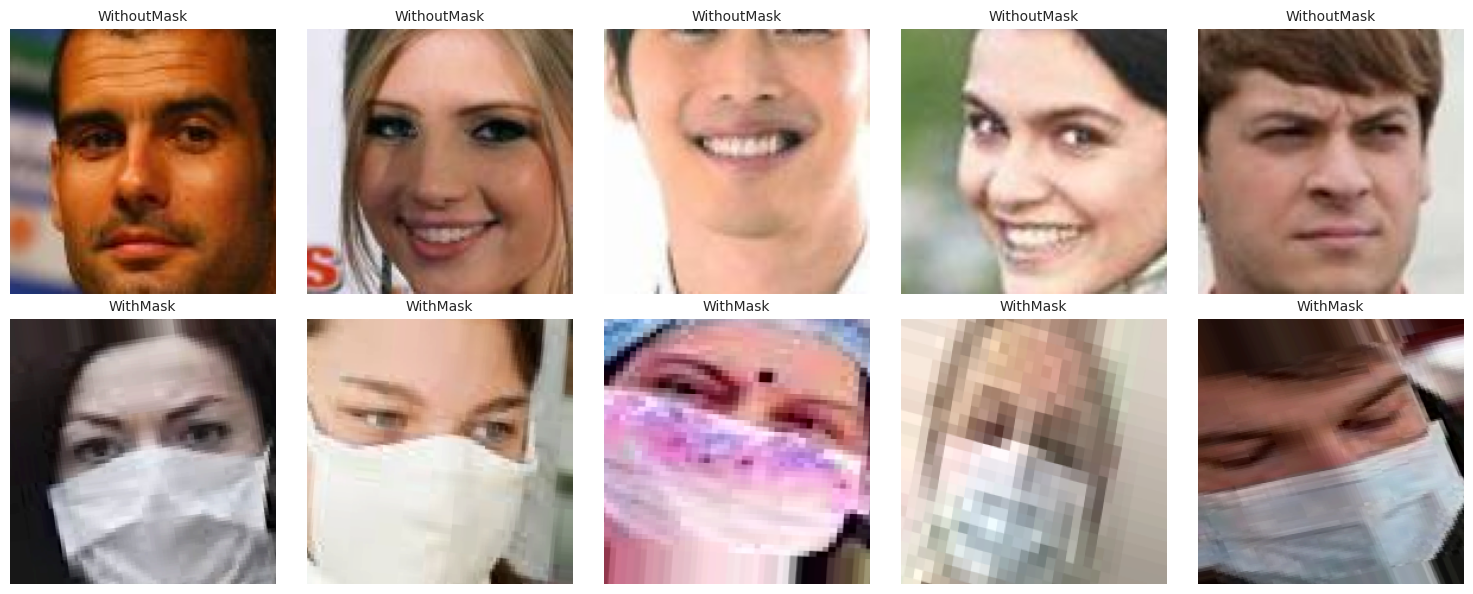

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Folder data (berdasarkan struktur kamu)
data_dir = "Face Mask Dataset/Train"

# Inisialisasi kamus gambar
mask_image = {}

# Loop setiap kelas dalam folder `train`
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        image_list = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        mask_image[class_name] = image_list

# Plot
fig, axs = plt.subplots(len(mask_image), 5, figsize=(15, 3 * len(mask_image)))

for i, class_name in enumerate(mask_image.keys()):
    # Ambil 5 gambar acak
    selected_images = np.random.choice(mask_image[class_name], 5, replace=False)

    for j, image_name in enumerate(selected_images):
        image_path = os.path.join(data_dir, class_name, image_name)
        img = Image.open(image_path).convert("RGB")
        axs[i, j].imshow(img)
        axs[i, j].set_title(class_name, fontsize=10)
        axs[i, j].axis("off")

plt.tight_layout()
plt.show()


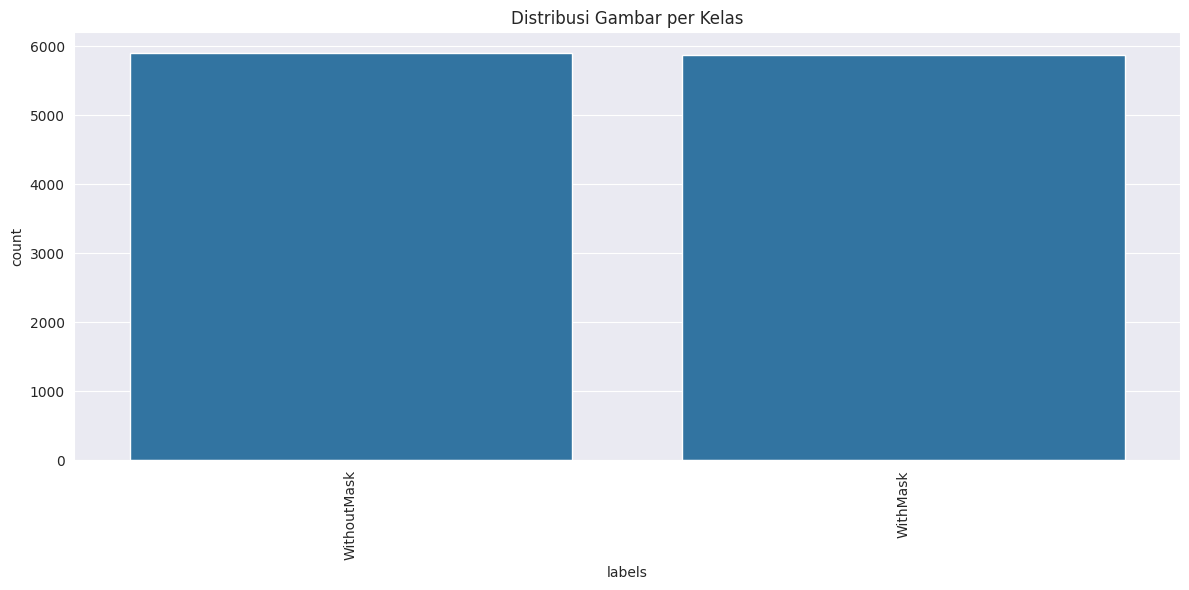

In [23]:
mask_path = "Face Mask Dataset/"
file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(mask_path):
    for name in files:
        if name.lower().endswith(('.png', '.jpg', '.jpeg')):
            full_path.append(os.path.join(path, name))
            labels.append(os.path.basename(path))  # label = nama folder
            file_name.append(name)

distribution_train = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

# Plot
plt.figure(figsize=(12,6))
sns.set_style("darkgrid")
sns.countplot(data=distribution_train, x="labels", order=distribution_train['labels'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Distribusi Gambar per Kelas")
plt.tight_layout()
plt.show()


In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random

# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.flip_up_down(img)
    return img

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.5))  # Sesuaikan nilai delta sesuai kebutuhan
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.random_blur(img, (3, 3))  # Ukuran kernel blur bisa disesuaikan
    return img

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter shearing range
    datagen = ImageDataGenerator(shear_range=0.2)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter width_shift_range dan height_shift_range
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

In [ ]:
import os
import random
import cv2
from skimage import io, img_as_ubyte

# Dictionary transformasi
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

base_path = "dataset/"
augmented_suffix = "_augmented"
images_to_generate = 10  # Jumlah augmentasi per kelas

# Loop ke semua kelas
for class_name in os.listdir(base_path):
    class_path = os.path.join(base_path, class_name)

    # Skip jika bukan folder
    if not os.path.isdir(class_path):
        continue

    # Siapkan path simpan augmented
    augmented_path = class_path + augmented_suffix
    os.makedirs(augmented_path, exist_ok=True)

    # Ambil semua file gambar dari kelas
    images = [
        os.path.join(class_path, im)
        for im in os.listdir(class_path)
        if im.lower().endswith(('.png', '.jpg', '.jpeg'))
    ]

    i = 1
    while i <= images_to_generate:
        image = random.choice(images)
        try:
            original_image = io.imread(image)
            if original_image.ndim not in [3, 4]:
                raise ValueError('Invalid image dimensions')

            transformed_image = original_image.copy()
            n = 0
            transformation_count = random.randint(1, len(transformations))

            while n <= transformation_count:
                key = random.choice(list(transformations))
                transformed_image = transformations[key](transformed_image)
                n += 1

            new_image_path = os.path.join(augmented_path, f"{class_name}_augmented_{i}.jpg")
            transformed_image = img_as_ubyte(transformed_image)
            cv2.imwrite(new_image_path, transformed_image)
            i += 1
        except Exception as e:
            print(f"Could not process image {image}: {e}")


Output streaming akan dipotong hingga 5000 baris terakhir.
Could not process image dataset/WithoutMask/2697.png: Images of type float must be between -1 and 1.
Could not process image dataset/WithoutMask/5124.png: module 'tensorflow._api.v2.image' has no attribute 'random_blur'
Could not process image dataset/WithoutMask/3182.png: Images of type float must be between -1 and 1.
Could not process image dataset/WithoutMask/4236.png: module 'tensorflow._api.v2.image' has no attribute 'random_blur'
Could not process image dataset/WithoutMask/5778.png: Images of type float must be between -1 and 1.
Could not process image dataset/WithoutMask/3089.png: Images of type float must be between -1 and 1.
Could not process image dataset/WithoutMask/5204.png: Images of type float must be between -1 and 1.
Could not process image dataset/WithoutMask/4528.png: module 'tensorflow._api.v2.image' has no attribute 'random_blur'
Could not process image dataset/WithoutMask/3608.png: module 'tensorflow._api.v

In [25]:
import shutil
import os

folder_path = 'Face Mask Dataset/dataset/WithMask_augmented'

# Cek dulu apakah folder-nya ada
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"Folder '{folder_path}' berhasil dihapus.")
else:
    print(f"Folder '{folder_path}' tidak ditemukan.")

Folder 'Face Mask Dataset/dataset/WithMask_augmented' tidak ditemukan.


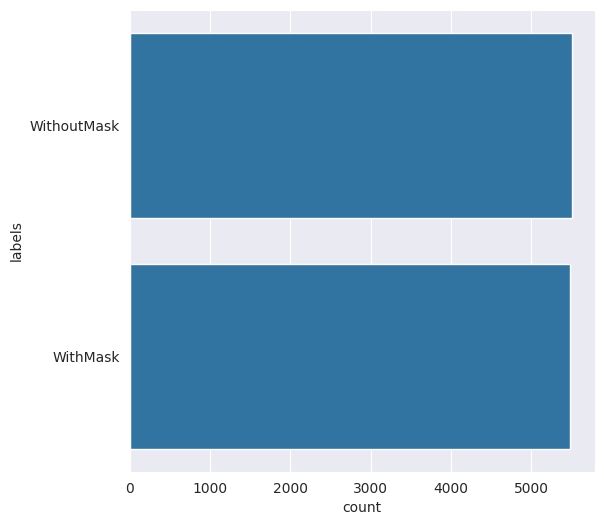

In [26]:
# Define source path
mask_path = "dataset/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(mask_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [27]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
WithMask,5483
WithoutMask,5509


In [28]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [29]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [30]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 8793
test size 2199


In [31]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels     
test   WithMask       1119
       WithoutMask    1080
train  WithMask       4364
       WithoutMask    4429
dtype: int64 


                                            path       labels    set
4531                dataset/WithoutMask/3565.png  WithoutMask  train
7167  dataset/WithMask/Augmented_569_2915532.png     WithMask  train
6184  dataset/WithMask/Augmented_213_8004630.png     WithMask  train
9665  dataset/WithMask/Augmented_108_7314799.png     WithMask   test
5201                dataset/WithoutMask/3546.png  WithoutMask  train


In [32]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "dataset/"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

In [33]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [34]:
# Define training and test directories
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_WithMask = os.path.join(TRAIN_DIR + '/WithMask')
train_WithoutMask = os.path.join(TRAIN_DIR + '/WithoutMask')
test_WithMask = os.path.join(TEST_DIR + '/WithMask')
test_WithoutMask = os.path.join(TEST_DIR + '/WithoutMask')

print("Total number of people With Mask images in training set: ",len(os.listdir(train_WithMask)))
print("Total number of people Without Mask images in training set: ",len(os.listdir(train_WithoutMask)))
print("Total number of people With Mask images in test set: ",len(os.listdir(train_WithMask)))
print("Total number of people Without Mask images in test set: ",len(os.listdir(train_WithoutMask)))

Total number of people With Mask images in training set:  4364
Total number of people Without Mask images in training set:  4429
Total number of people With Mask images in test set:  4364
Total number of people Without Mask images in test set:  4429


In [35]:
# Create an ImageDataGenerator object normalizing the images
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="grayscale",
                                              class_mode='binary',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   color_mode="grayscale",
                                                   class_mode='binary',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="grayscale",
                                                  class_mode='binary',
                                                  shuffle=False)

Found 7036 images belonging to 2 classes.
Found 1757 images belonging to 2 classes.
Found 2199 images belonging to 2 classes.


## Modelling

In [36]:
# tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_1 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Flatten layer
model_1.add(Flatten())
# 1nd Dense Layer
model_1.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_1.add(Dropout(0.5))
# 2nd Dense Layer
model_1.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_1.add(Dropout(0.3))

# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_1.add(Dense(1, activation='sigmoid'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_1.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,402,881 (5.35 MB)

 Trainable params: 1,402,689 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


In [37]:
count_WithMask, count_WithoutMask = len(os.listdir(train_WithMask)), len(os.listdir(train_WithoutMask))
weight_0 = (1 / count_WithMask) * (count_WithMask + count_WithoutMask) / 2.0
weight_1 = (1 / count_WithoutMask) * (count_WithoutMask + count_WithMask) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}

%time

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

# Fitting / training model with callbacks
history_1 = model_1.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight=class_weights,
                        callbacks=[early_stopping, model_checkpoint])


CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 19.8 µs


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8551 - loss: 0.5696

220/220 ━━━━━━━━━━━━━━━━━━━━ 453s 2s/step - accuracy: 0.8554 - loss: 0.5686 - val_accuracy: 0.5122 - val_loss: 1.8034
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9717 - loss: 0.1301

220/220 ━━━━━━━━━━━━━━━━━━━━ 454s 2s/step - accuracy: 0.9717 - loss: 0.1301 - val_accuracy: 0.5481 - val_loss: 2.5293
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9876 - loss: 0.0527

220/220 ━━━━━━━━━━━━━━━━━━━━ 462s 2s/step - accuracy: 0.9876 - loss: 0.0527 - val_accuracy: 0.7308 - val_loss: 2.2987
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9883 - loss: 0.0644

220/220 ━━━━━━━━━━━━━━━━━━━━ 455s 2s/step - accuracy: 0.9883 - loss: 0.0644 - val_accuracy: 0.9061 - val_loss: 0.8693
Epoch 5/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9947 - loss: 0.0248

220/220 ━━━━━━━━━━━━━━━━━━━━ 519s 2s/step - accuracy: 0.9947 - loss: 0.0249 - val_accuracy: 0.9158 - val_loss: 1.2716
Epoch 6/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 447s 2s/step - accuracy: 0.9942 - loss: 0.0269 - val_accuracy: 0.8327 - val_loss: 2.7869
Epoch 7/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 447s 2s/step - accuracy: 0.9903 - loss: 0.0537 - val_accuracy: 0.8486 - val_loss: 2.0013
Epoch 8/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 502s 2s/step - accuracy: 0.9945 - loss: 0.0285 - val_accuracy: 0.6221 - val_loss: 5.2007
Epoch 9/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 449s 2s/step - accuracy: 0.9958 - loss: 0.0180 - val_accuracy: 0.8993 - val_loss: 2.0195


In [38]:
# Load model terbaik yang disimpan
from tensorflow.keras.models import load_model

best_model = load_model('best_model.h5')

# Evaluasi model di test set
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"Testing Accuracy: {test_accuracy:.4f}")

2199/2199 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - accuracy: 0.9489 - loss: 1.0889
Testing Accuracy: 0.9477


## Evaluasi dan Visualisasi

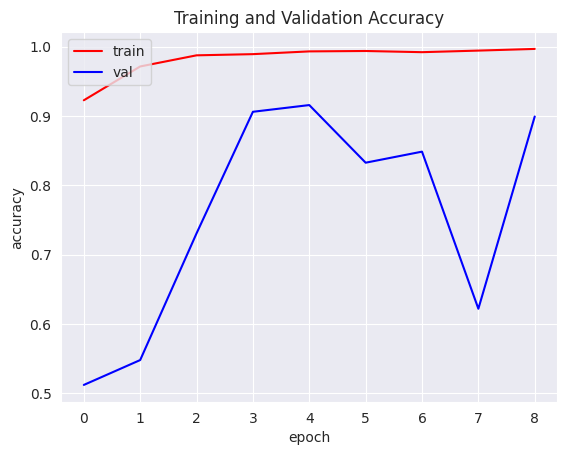

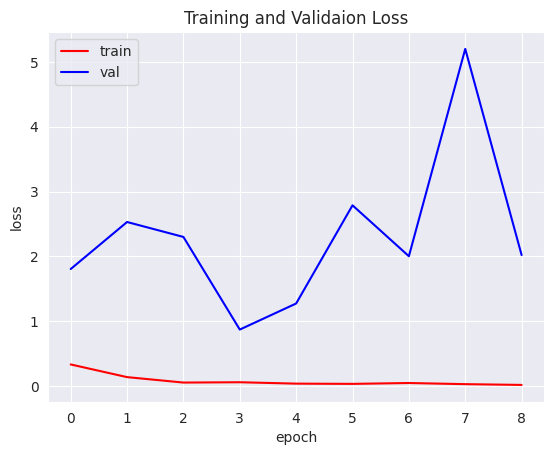

In [39]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

   With Mask     0.9880    0.9535    0.9704      1119
Without Mask     0.9535    0.9880    0.9704      1080

    accuracy                         0.9704      2199
   macro avg     0.9707    0.9707    0.9704      2199
weighted avg     0.9711    0.9704    0.9704      2199



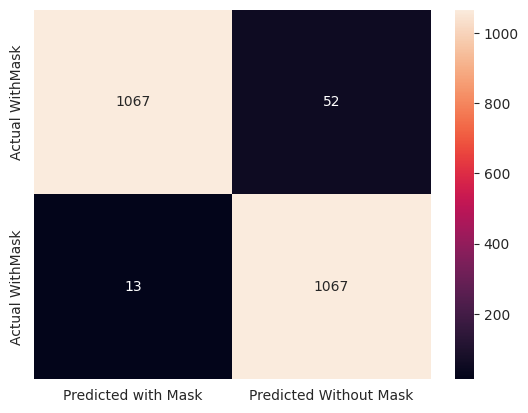

In [41]:
test_generator.reset()

preds_1 = model_1.predict(test_generator,verbose=0)
preds_1 = preds_1.copy()
preds_1[preds_1 <= 0.5] = 0
preds_1[preds_1 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1, labels=[0, 1]),index=["Actual WithMask", "Actual WithMask"],
columns=["Predicted with Mask", "Predicted Without Mask"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_1,target_names =['With Mask','Without Mask'], digits=4))

## Konversi Model

In [43]:
saved_model_dir = "saved_model"
tf.saved_model.save(model_1, saved_model_dir)
print(f"Model saved to {saved_model_dir}")

Model saved to saved_model


In [47]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [48]:
import os

labels = ["WithMask", "WithoutMask"]
tflite_dir = "tflite_model"
os.makedirs(tflite_dir, exist_ok=True)

label_txt_path = os.path.join(tflite_dir, "label.txt")
with open(label_txt_path, "w") as f:
    for label in labels:
        f.write(label + "\n")
print(f"Labels saved to {label_txt_path}")

Labels saved to tflite_model/label.txt


In [49]:
tfjs_model_dir = "tfjs_model"
os.makedirs(tfjs_model_dir, exist_ok=True)

!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model {saved_model_dir} {tfjs_model_dir}
print(f"TFJS model saved to {tfjs_model_dir}")

/bin/bash: line 1: tensorflowjs_converter: command not found
TFJS model saved to tfjs_model


## Inference (Optional)